# Binary Classification Model - Sonar Dataset

The task of the trained model is to train a network to discriminate between sonar signals bounced off a metal cylinder and those bounced off a roughly cylindrical rock.

### Step 1: Import libraries and packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


### Step 2: Set the seed
Sets the starting integer value while generating the random numbers.That means that  a random result will occur everytime a line of code is run without specifying random_state, this is expected behavior. Examples can be seen when shuffling data i.e. K-Fold cross validation

In [2]:
seed = 7
np.random.seed(seed)

### Step 3: Import data

In [3]:
dataframe = pd.read_csv("sonar.csv", delimiter = ',')
dataset = dataframe.values

In [4]:
X = dataset[:,0:60].astype(float)
Y = dataset[:,60]

### Step 4: Defining the model

The Sequential model is a 'box' that contain layers of the neural network. 
As exhibited, there are three Dense layers in this model - which means that all layers are fully connected. 
i.e all neurons are connected to each other.

Input dimension: It is the number of columns in the tabular data set. (this is also the number of attributes)

Activation functions  
Relu: Rectified linear unit function, it has a low tax on computational memory due to its simple algorithim, it also provides sparsity which aids in predicting unknown/future data.
Sigmoid: Replaces Final layer in a binary classification model always has a sigmoid activation fucntion as it has to produce a probability output between 0 and 1.

Finally, the digits in each layer represent number of neurons in each layer. Realise the last layer has one neuron that is our output.

In [5]:
def create_baseline():
    # create model
    model=Sequential()
    model.add(Dense(60, input_dim=60, activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

#### Note
K-Fold cross validation is used to enhance the overall performance of the model. Shuffling 10 folds, each with 30 sections. The seed comes works as a checkpoint in this instance, it allows themodel to provide consistant loss and accuracy measurements

In [6]:
estimator = KerasClassifier(build_fn=create_baseline, epochs = 100, batch_size = 50, verbose = 0) 
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)
results = cross_val_score(estimator, X,Y, cv = kfold)
print("Baseline: %.2f%% (%.2f%%)" %(results.mean()*100, results.std()*100))

Baseline: 81.07% (7.23%)


###  Step 5: Data preparation 

Data can be prepared using scikit-learn 'StandardScaler' function. This standardises our tabular data and preserves Gaussian-like (normal dist.) whilst normalising tendencies for each attribute.

Another function from scikit-learn is Pipeline, this allows standardization to affect solely the training data. Often used once initial exploration is done. It chains different transformers and estimators and applies them to the training data. Ultimately looping through several models to find the best one. In this case Pipeline will be used as an estimator and pass to cross validation.

In [7]:
np.random.seed(seed)
estimators = []
estimators.append(('standardise', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs = 100, batch_size = 50, verbose = 0))) 
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)
results = cross_val_score(pipeline, X, Y, cv = kfold)
print("Standardised: %.2f%% (%.2f%%)" %(results.mean()*100, results.std()*100))

Standardised: 84.54% (6.68%)


### Step 7: Tuning the model - Layers and Hyperparameters

Improving a neural network is achievable by tuning various things such as the optimizer's learning rate, activation functions, number of neurons and layers, etc. Two models have been created below based off of our baseline model: 1) Smaller model with half the neurons in previous model (60 to 30). This puts pressure on the network to pick most important structure in the input data to model. (This will also be standardised to boost performance).

In [8]:
def create_smaller():
    # create model
    model = Sequential()
    model.add(Dense(30, input_dim=60, activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model
estimators = []
estimators.append(('standardise', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_smaller, epochs = 100, batch_size = 50, verbose = 0))) 
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)
results = cross_val_score(pipeline, X, Y, cv = kfold)
print("Smaller: %.2f%% (%.2f%%)" %(results.mean()*100, results.std()*100))

Smaller: 84.11% (6.31%)


#### Note
Expanding the model to include an extra layer has actually increased overall performance. 

In [9]:
def create_larger():
    # create model
    model = Sequential()
    model.add(Dense(60, input_dim=60, activation = 'relu'))
    model.add(Dense(40, activation = 'relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model
estimators = []
estimators.append(('standardise', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_larger, epochs = 100, batch_size = 50, verbose = 0))) 
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)
results = cross_val_score(pipeline, X, Y, cv = kfold)
print("Larger: %.2f%% (%.2f%%)" %(results.mean()*100, results.std()*100))

Larger: 84.07% (6.40%)


### Dropout layer
Adding a dropout layer to the stratified model had improved both loss and accuracy, however by conducting further analysis and optimising hyper parameters, its been evident that at a certain number of epochs data starts to overfit.

In [10]:
model=Sequential()
model.add(Dense(60, input_dim=60, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer = optimizers.adam(lr=0.001), metrics = ['accuracy'])
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)
# fit the model
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size= 0.25, random_state=seed)
history = model.fit(x_train,y_train, validation_data= (x_test,y_test), epochs = 500, batch_size = 200)
# list all data in history

Train on 155 samples, validate on 52 samples
Epoch 1/500
155/155 [==============================] - 4s 26ms/step - loss: 0.7552 - acc: 0.4645 - val_loss: 0.7567 - val_acc: 0.3269
Epoch 2/500
155/155 [==============================] - 0s 64us/step - loss: 0.7615 - acc: 0.4645 - val_loss: 0.7451 - val_acc: 0.3077
Epoch 3/500
155/155 [==============================] - 0s 74us/step - loss: 0.7755 - acc: 0.3677 - val_loss: 0.7353 - val_acc: 0.3269
Epoch 4/500
155/155 [==============================] - 0s 72us/step - loss: 0.7216 - acc: 0.4710 - val_loss: 0.7281 - val_acc: 0.3462
Epoch 5/500
155/155 [==============================] - 0s 59us/step - loss: 0.7465 - acc: 0.3935 - val_loss: 0.7219 - val_acc: 0.4423
Epoch 6/500
155/155 [==============================] - 0s 64us/step - loss: 0.7231 - acc: 0.5032 - val_loss: 0.7168 - val_acc: 0.4615
Epoch 7/500
155/155 [==============================] - 0s 60us/step - loss: 0.7264 - acc: 0.4516 - val_loss: 0.7128 - val_acc: 0.5385
Epoch 8/500
155/1

Epoch 62/500
155/155 [==============================] - 0s 82us/step - loss: 0.5767 - acc: 0.7419 - val_loss: 0.5790 - val_acc: 0.7115
Epoch 63/500
155/155 [==============================] - 0s 106us/step - loss: 0.5579 - acc: 0.7742 - val_loss: 0.5771 - val_acc: 0.7115
Epoch 64/500
155/155 [==============================] - 0s 71us/step - loss: 0.5610 - acc: 0.7742 - val_loss: 0.5752 - val_acc: 0.7115
Epoch 65/500
155/155 [==============================] - 0s 82us/step - loss: 0.5557 - acc: 0.7677 - val_loss: 0.5734 - val_acc: 0.7115
Epoch 66/500
155/155 [==============================] - 0s 66us/step - loss: 0.5591 - acc: 0.7806 - val_loss: 0.5717 - val_acc: 0.7115
Epoch 67/500
155/155 [==============================] - 0s 80us/step - loss: 0.5562 - acc: 0.7742 - val_loss: 0.5700 - val_acc: 0.7115
Epoch 68/500
155/155 [==============================] - 0s 84us/step - loss: 0.5387 - acc: 0.7871 - val_loss: 0.5681 - val_acc: 0.7115
Epoch 69/500
155/155 [==============================] 

Epoch 123/500
155/155 [==============================] - 0s 80us/step - loss: 0.4522 - acc: 0.8194 - val_loss: 0.4905 - val_acc: 0.7308
Epoch 124/500
155/155 [==============================] - 0s 70us/step - loss: 0.4511 - acc: 0.8516 - val_loss: 0.4901 - val_acc: 0.7308
Epoch 125/500
155/155 [==============================] - 0s 72us/step - loss: 0.4654 - acc: 0.7871 - val_loss: 0.4898 - val_acc: 0.7308
Epoch 126/500
155/155 [==============================] - 0s 71us/step - loss: 0.4718 - acc: 0.7871 - val_loss: 0.4891 - val_acc: 0.7308
Epoch 127/500
155/155 [==============================] - 0s 84us/step - loss: 0.4413 - acc: 0.8258 - val_loss: 0.4884 - val_acc: 0.7308
Epoch 128/500
155/155 [==============================] - 0s 69us/step - loss: 0.4565 - acc: 0.8065 - val_loss: 0.4874 - val_acc: 0.7308
Epoch 129/500
155/155 [==============================] - 0s 61us/step - loss: 0.4403 - acc: 0.8452 - val_loss: 0.4865 - val_acc: 0.7308
Epoch 130/500
155/155 [=========================

Epoch 184/500
155/155 [==============================] - 0s 80us/step - loss: 0.3995 - acc: 0.8452 - val_loss: 0.4441 - val_acc: 0.7500
Epoch 185/500
155/155 [==============================] - 0s 70us/step - loss: 0.3872 - acc: 0.8452 - val_loss: 0.4439 - val_acc: 0.7500
Epoch 186/500
155/155 [==============================] - 0s 77us/step - loss: 0.3846 - acc: 0.8387 - val_loss: 0.4437 - val_acc: 0.7500
Epoch 187/500
155/155 [==============================] - 0s 76us/step - loss: 0.3822 - acc: 0.8581 - val_loss: 0.4438 - val_acc: 0.7500
Epoch 188/500
155/155 [==============================] - 0s 63us/step - loss: 0.3861 - acc: 0.8645 - val_loss: 0.4439 - val_acc: 0.7500
Epoch 189/500
155/155 [==============================] - 0s 68us/step - loss: 0.4030 - acc: 0.8581 - val_loss: 0.4439 - val_acc: 0.7500
Epoch 190/500
155/155 [==============================] - 0s 64us/step - loss: 0.3942 - acc: 0.8710 - val_loss: 0.4439 - val_acc: 0.7500
Epoch 191/500
155/155 [=========================

Epoch 245/500
155/155 [==============================] - 0s 73us/step - loss: 0.3623 - acc: 0.8645 - val_loss: 0.4250 - val_acc: 0.7500
Epoch 246/500
155/155 [==============================] - 0s 103us/step - loss: 0.3400 - acc: 0.8839 - val_loss: 0.4246 - val_acc: 0.7500
Epoch 247/500
155/155 [==============================] - 0s 129us/step - loss: 0.3388 - acc: 0.8710 - val_loss: 0.4240 - val_acc: 0.7500
Epoch 248/500
155/155 [==============================] - 0s 78us/step - loss: 0.3362 - acc: 0.8903 - val_loss: 0.4241 - val_acc: 0.7500
Epoch 249/500
155/155 [==============================] - 0s 80us/step - loss: 0.3479 - acc: 0.8581 - val_loss: 0.4240 - val_acc: 0.7500
Epoch 250/500
155/155 [==============================] - 0s 71us/step - loss: 0.3422 - acc: 0.8839 - val_loss: 0.4238 - val_acc: 0.7500
Epoch 251/500
155/155 [==============================] - 0s 68us/step - loss: 0.3570 - acc: 0.8516 - val_loss: 0.4241 - val_acc: 0.7500
Epoch 252/500
155/155 [=======================

Epoch 306/500
155/155 [==============================] - 0s 81us/step - loss: 0.2946 - acc: 0.8968 - val_loss: 0.4161 - val_acc: 0.8269
Epoch 307/500
155/155 [==============================] - 0s 77us/step - loss: 0.3009 - acc: 0.8839 - val_loss: 0.4146 - val_acc: 0.8269
Epoch 308/500
155/155 [==============================] - 0s 79us/step - loss: 0.2817 - acc: 0.9161 - val_loss: 0.4137 - val_acc: 0.8269
Epoch 309/500
155/155 [==============================] - 0s 93us/step - loss: 0.3198 - acc: 0.8516 - val_loss: 0.4133 - val_acc: 0.8269
Epoch 310/500
155/155 [==============================] - 0s 68us/step - loss: 0.3032 - acc: 0.9097 - val_loss: 0.4136 - val_acc: 0.8269
Epoch 311/500
155/155 [==============================] - 0s 75us/step - loss: 0.3073 - acc: 0.8968 - val_loss: 0.4144 - val_acc: 0.8269
Epoch 312/500
155/155 [==============================] - 0s 63us/step - loss: 0.3185 - acc: 0.8710 - val_loss: 0.4148 - val_acc: 0.8269
Epoch 313/500
155/155 [=========================

Epoch 367/500
155/155 [==============================] - 0s 75us/step - loss: 0.2784 - acc: 0.8968 - val_loss: 0.4116 - val_acc: 0.8462
Epoch 368/500
155/155 [==============================] - 0s 75us/step - loss: 0.2629 - acc: 0.9226 - val_loss: 0.4111 - val_acc: 0.8462
Epoch 369/500
155/155 [==============================] - 0s 68us/step - loss: 0.2875 - acc: 0.8903 - val_loss: 0.4107 - val_acc: 0.8269
Epoch 370/500
155/155 [==============================] - 0s 76us/step - loss: 0.2835 - acc: 0.9097 - val_loss: 0.4110 - val_acc: 0.8269
Epoch 371/500
155/155 [==============================] - 0s 75us/step - loss: 0.2824 - acc: 0.8839 - val_loss: 0.4109 - val_acc: 0.8269
Epoch 372/500
155/155 [==============================] - 0s 70us/step - loss: 0.2681 - acc: 0.9097 - val_loss: 0.4106 - val_acc: 0.8269
Epoch 373/500
155/155 [==============================] - 0s 71us/step - loss: 0.2771 - acc: 0.8968 - val_loss: 0.4102 - val_acc: 0.8269
Epoch 374/500
155/155 [=========================

155/155 [==============================] - 0s 139us/step - loss: 0.2543 - acc: 0.9097 - val_loss: 0.4073 - val_acc: 0.8269
Epoch 428/500
155/155 [==============================] - 0s 208us/step - loss: 0.2504 - acc: 0.9097 - val_loss: 0.4076 - val_acc: 0.8462
Epoch 429/500
155/155 [==============================] - 0s 185us/step - loss: 0.2570 - acc: 0.9161 - val_loss: 0.4077 - val_acc: 0.8462
Epoch 430/500
155/155 [==============================] - 0s 134us/step - loss: 0.2492 - acc: 0.9097 - val_loss: 0.4076 - val_acc: 0.8462
Epoch 431/500
155/155 [==============================] - 0s 95us/step - loss: 0.2384 - acc: 0.9161 - val_loss: 0.4076 - val_acc: 0.8462
Epoch 432/500
155/155 [==============================] - 0s 107us/step - loss: 0.2403 - acc: 0.9097 - val_loss: 0.4076 - val_acc: 0.8269
Epoch 433/500
155/155 [==============================] - 0s 136us/step - loss: 0.2679 - acc: 0.9032 - val_loss: 0.4076 - val_acc: 0.8269
Epoch 434/500
155/155 [==============================] -

155/155 [==============================] - 0s 98us/step - loss: 0.2220 - acc: 0.9355 - val_loss: 0.4160 - val_acc: 0.8462
Epoch 488/500
155/155 [==============================] - 0s 111us/step - loss: 0.2232 - acc: 0.9290 - val_loss: 0.4155 - val_acc: 0.8462
Epoch 489/500
155/155 [==============================] - 0s 92us/step - loss: 0.2188 - acc: 0.9226 - val_loss: 0.4152 - val_acc: 0.8462
Epoch 490/500
155/155 [==============================] - 0s 113us/step - loss: 0.2195 - acc: 0.9419 - val_loss: 0.4150 - val_acc: 0.8462
Epoch 491/500
155/155 [==============================] - 0s 122us/step - loss: 0.2129 - acc: 0.9226 - val_loss: 0.4149 - val_acc: 0.8462
Epoch 492/500
155/155 [==============================] - 0s 110us/step - loss: 0.2287 - acc: 0.8968 - val_loss: 0.4151 - val_acc: 0.8269
Epoch 493/500
155/155 [==============================] - 0s 169us/step - loss: 0.2348 - acc: 0.9161 - val_loss: 0.4155 - val_acc: 0.8462
Epoch 494/500
155/155 [==============================] - 

### Step 8: Plotting the data

Using the same model, the graph provides further insight into reliability of this model. As seen in the graph below, the data starts to overfit around 200 epochs. Further tuning is required. 

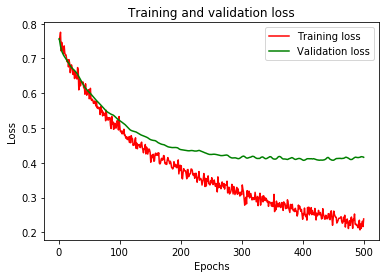

In [11]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

train_line = 'r'
val_line = 'g'

plt.plot(epochs, loss, train_line, label = 'Training loss')
plt.plot(epochs, val_loss, val_line, label = 'Validation loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### EarlyStopping
By implementing EarlyStopping this allows us to find peak performance utilising the following settings, any further and the data starts to be exposed to overfitting.

In [12]:
model=Sequential()
model.add(Dense(60, input_dim=60, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
# compile model
model.compile(loss='binary_crossentropy', optimizer = optimizers.adam(lr = 0.001), metrics = ['accuracy'])
# Apply earlystopping
earlystopping = callbacks.EarlyStopping(monitor ='val_loss', patience = 0, verbose = 0, mode = 'auto')
# fit the model
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size= 0.25, random_state=seed)
history = model.fit(x_train,y_train, validation_data= (x_test,y_test), epochs = 500, batch_size = 200, callbacks = [earlystopping])
# list all data in history

Train on 155 samples, validate on 52 samples
Epoch 1/500
155/155 [==============================] - 5s 31ms/step - loss: 0.7155 - acc: 0.4774 - val_loss: 0.7010 - val_acc: 0.4423
Epoch 2/500
155/155 [==============================] - 0s 63us/step - loss: 0.6904 - acc: 0.5097 - val_loss: 0.6945 - val_acc: 0.4423
Epoch 3/500
155/155 [==============================] - 0s 59us/step - loss: 0.6977 - acc: 0.5161 - val_loss: 0.6888 - val_acc: 0.6154
Epoch 4/500
155/155 [==============================] - 0s 127us/step - loss: 0.6857 - acc: 0.5419 - val_loss: 0.6849 - val_acc: 0.6154
Epoch 5/500
155/155 [==============================] - 0s 84us/step - loss: 0.6742 - acc: 0.5742 - val_loss: 0.6823 - val_acc: 0.5769
Epoch 6/500
155/155 [==============================] - 0s 69us/step - loss: 0.6912 - acc: 0.5484 - val_loss: 0.6805 - val_acc: 0.5577
Epoch 7/500
155/155 [==============================] - 0s 60us/step - loss: 0.6904 - acc: 0.5677 - val_loss: 0.6791 - val_acc: 0.5577
Epoch 8/500
155/

Epoch 62/500
155/155 [==============================] - 0s 114us/step - loss: 0.5705 - acc: 0.7484 - val_loss: 0.5880 - val_acc: 0.6923
Epoch 63/500
155/155 [==============================] - 0s 100us/step - loss: 0.5699 - acc: 0.7613 - val_loss: 0.5862 - val_acc: 0.6923
Epoch 64/500
155/155 [==============================] - 0s 104us/step - loss: 0.5668 - acc: 0.7548 - val_loss: 0.5846 - val_acc: 0.6923
Epoch 65/500
155/155 [==============================] - 0s 104us/step - loss: 0.5682 - acc: 0.7613 - val_loss: 0.5831 - val_acc: 0.6923
Epoch 66/500
155/155 [==============================] - 0s 120us/step - loss: 0.5663 - acc: 0.7548 - val_loss: 0.5816 - val_acc: 0.6923
Epoch 67/500
155/155 [==============================] - 0s 157us/step - loss: 0.5610 - acc: 0.7484 - val_loss: 0.5800 - val_acc: 0.6923
Epoch 68/500
155/155 [==============================] - 0s 75us/step - loss: 0.5607 - acc: 0.7548 - val_loss: 0.5784 - val_acc: 0.6923
Epoch 69/500
155/155 [===========================

Epoch 123/500
155/155 [==============================] - 0s 73us/step - loss: 0.4647 - acc: 0.8129 - val_loss: 0.4904 - val_acc: 0.7308
Epoch 124/500
155/155 [==============================] - 0s 81us/step - loss: 0.4500 - acc: 0.8516 - val_loss: 0.4892 - val_acc: 0.7308
Epoch 125/500
155/155 [==============================] - 0s 76us/step - loss: 0.4530 - acc: 0.8645 - val_loss: 0.4882 - val_acc: 0.7308
Epoch 126/500
155/155 [==============================] - 0s 78us/step - loss: 0.4610 - acc: 0.8065 - val_loss: 0.4870 - val_acc: 0.7308
Epoch 127/500
155/155 [==============================] - 0s 67us/step - loss: 0.4553 - acc: 0.8387 - val_loss: 0.4859 - val_acc: 0.7308
Epoch 128/500
155/155 [==============================] - 0s 69us/step - loss: 0.4425 - acc: 0.8258 - val_loss: 0.4846 - val_acc: 0.7308
Epoch 129/500
155/155 [==============================] - 0s 72us/step - loss: 0.4504 - acc: 0.8645 - val_loss: 0.4832 - val_acc: 0.7308
Epoch 130/500
155/155 [=========================

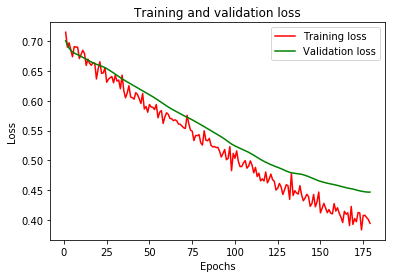

In [13]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

train_line = 'r'
val_line = 'g'

plt.plot(epochs, loss, train_line, label = 'Training loss')
plt.plot(epochs, val_loss, val_line, label = 'Validation loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Note
Accuracy for both data types are over 0.70 
However, the increase in training accuracy may lead to overfitting. Discrepancies with accuracy could be a result from implementing a dropout layer solely on training data.

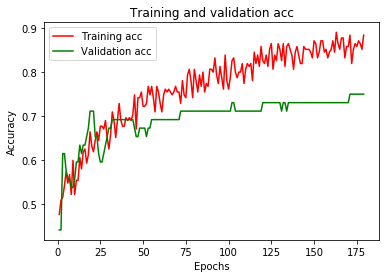

In [14]:
plt.clf()

acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'r', label = 'Training acc')
plt.plot(epochs, val_acc, 'g', label = 'Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [15]:
model = Sequential()
model.add(Dense(60, input_dim=60, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])
model.fit(x_train, y_train, epochs = 300, batch_size = 50, verbose = 1)

results = model.evaluate(x_test, y_test)

print(results)

Epoch 1/300
155/155 [==============================] - 4s 26ms/step - loss: 0.7623 - acc: 0.4387
Epoch 2/300
155/155 [==============================] - 0s 151us/step - loss: 0.6972 - acc: 0.4968
Epoch 3/300
155/155 [==============================] - 0s 157us/step - loss: 0.6850 - acc: 0.5290
Epoch 4/300
155/155 [==============================] - 0s 196us/step - loss: 0.6836 - acc: 0.5613
Epoch 5/300
155/155 [==============================] - 0s 193us/step - loss: 0.6837 - acc: 0.5806
Epoch 6/300
155/155 [==============================] - 0s 190us/step - loss: 0.6749 - acc: 0.6129
Epoch 7/300
155/155 [==============================] - 0s 192us/step - loss: 0.6429 - acc: 0.6710
Epoch 8/300
155/155 [==============================] - 0s 206us/step - loss: 0.6556 - acc: 0.5806
Epoch 9/300
155/155 [==============================] - 0s 243us/step - loss: 0.6525 - acc: 0.6452
Epoch 10/300
155/155 [==============================] - 0s 208us/step - loss: 0.6206 - acc: 0.6516
Epoch 11/300
155/155

155/155 [==============================] - 0s 164us/step - loss: 0.4395 - acc: 0.8452
Epoch 84/300
155/155 [==============================] - 0s 195us/step - loss: 0.4580 - acc: 0.8129
Epoch 85/300
155/155 [==============================] - 0s 187us/step - loss: 0.4416 - acc: 0.8581
Epoch 86/300
155/155 [==============================] - 0s 187us/step - loss: 0.4647 - acc: 0.8129
Epoch 87/300
155/155 [==============================] - 0s 191us/step - loss: 0.4663 - acc: 0.8065
Epoch 88/300
155/155 [==============================] - 0s 188us/step - loss: 0.4367 - acc: 0.8194
Epoch 89/300
155/155 [==============================] - 0s 180us/step - loss: 0.4295 - acc: 0.8387
Epoch 90/300
155/155 [==============================] - 0s 158us/step - loss: 0.4547 - acc: 0.8387
Epoch 91/300
155/155 [==============================] - 0s 157us/step - loss: 0.4572 - acc: 0.8065
Epoch 92/300
155/155 [==============================] - 0s 152us/step - loss: 0.4280 - acc: 0.8194
Epoch 93/300
155/155 [=

155/155 [==============================] - 0s 165us/step - loss: 0.3597 - acc: 0.8516
Epoch 166/300
155/155 [==============================] - 0s 177us/step - loss: 0.3704 - acc: 0.8387
Epoch 167/300
155/155 [==============================] - 0s 198us/step - loss: 0.3341 - acc: 0.8903
Epoch 168/300
155/155 [==============================] - 0s 213us/step - loss: 0.3454 - acc: 0.8774
Epoch 169/300
155/155 [==============================] - 0s 200us/step - loss: 0.3583 - acc: 0.8903
Epoch 170/300
155/155 [==============================] - 0s 196us/step - loss: 0.3434 - acc: 0.8839
Epoch 171/300
155/155 [==============================] - 0s 177us/step - loss: 0.3555 - acc: 0.8387
Epoch 172/300
155/155 [==============================] - 0s 161us/step - loss: 0.3362 - acc: 0.8968
Epoch 173/300
155/155 [==============================] - 0s 160us/step - loss: 0.3371 - acc: 0.8710
Epoch 174/300
155/155 [==============================] - 0s 157us/step - loss: 0.3383 - acc: 0.8645
Epoch 175/300


155/155 [==============================] - 0s 178us/step - loss: 0.2883 - acc: 0.8774
Epoch 248/300
155/155 [==============================] - 0s 184us/step - loss: 0.2814 - acc: 0.8903
Epoch 249/300
155/155 [==============================] - 0s 170us/step - loss: 0.2710 - acc: 0.9032
Epoch 250/300
155/155 [==============================] - 0s 186us/step - loss: 0.3100 - acc: 0.8839
Epoch 251/300
155/155 [==============================] - 0s 162us/step - loss: 0.2897 - acc: 0.8968
Epoch 252/300
155/155 [==============================] - 0s 161us/step - loss: 0.2791 - acc: 0.8968
Epoch 253/300
155/155 [==============================] - 0s 201us/step - loss: 0.2627 - acc: 0.9161
Epoch 254/300
155/155 [==============================] - 0s 233us/step - loss: 0.2915 - acc: 0.9032
Epoch 255/300
155/155 [==============================] - 0s 171us/step - loss: 0.2775 - acc: 0.9097
Epoch 256/300
155/155 [==============================] - 0s 157us/step - loss: 0.2715 - acc: 0.9161
Epoch 257/300


### Test Data / Conclusion

Finally we can see that test_loss and test_accuracy are actually improving therefore the model is able to predict whether sonar sound is being bounced off a metal or rock cylinder.
Further tuning can be done to further reduce the noise and continuously improve the model.